# Demonstration for working with TEMPO data via `Harmony-py`

## Overview

This notebook demonstrates how to retrieve and visualize TEMPO data using `harmony-py`.

### Prerequisites

A free(!) account at https://www.earthdata.nasa.gov/ is needed to login and download the appropriate files.

This notebook was last tested using Python 3.10.15, and requires these libraries:

- [harmony-py](https://github.com/nasa/harmony-py)
- [matplotlib](http://matplotlib.org/)
- [numpy](https://numpy.org/)
- [python-cmr]
- [netCDF4]
- [xarray]
- [geopandas]
- [wget]

## Note

This notebook is based on examples from the [harmony-py repository](https://github.com/nasa/harmony-py/tree/main/examples) and https://harmony.earthdata.nasa.gov/docs.
- Created: 3 May 2023
- Last updated: 7 May 2025

## What is Harmony?
Harmony is the **cloud services orchestrator** for [NASA Earth Science Data and Information System (ESDIS)](https://www.earthdata.nasa.gov/esdis). The goal of Harmony is to provide services to increase usage and ease of use of ESDIS' Earth observation data, especially focusing on opportunities made possible by cloud-accessible data. 

Data processed by Harmony are staged in Amazon s3 buckets, and Harmony services run in containers in pods in a Kubernetes cluster.

Note that services provided via Harmony **can transform NASA data as well as provide access to the original data**, through an Application Programmable Interface (API)...

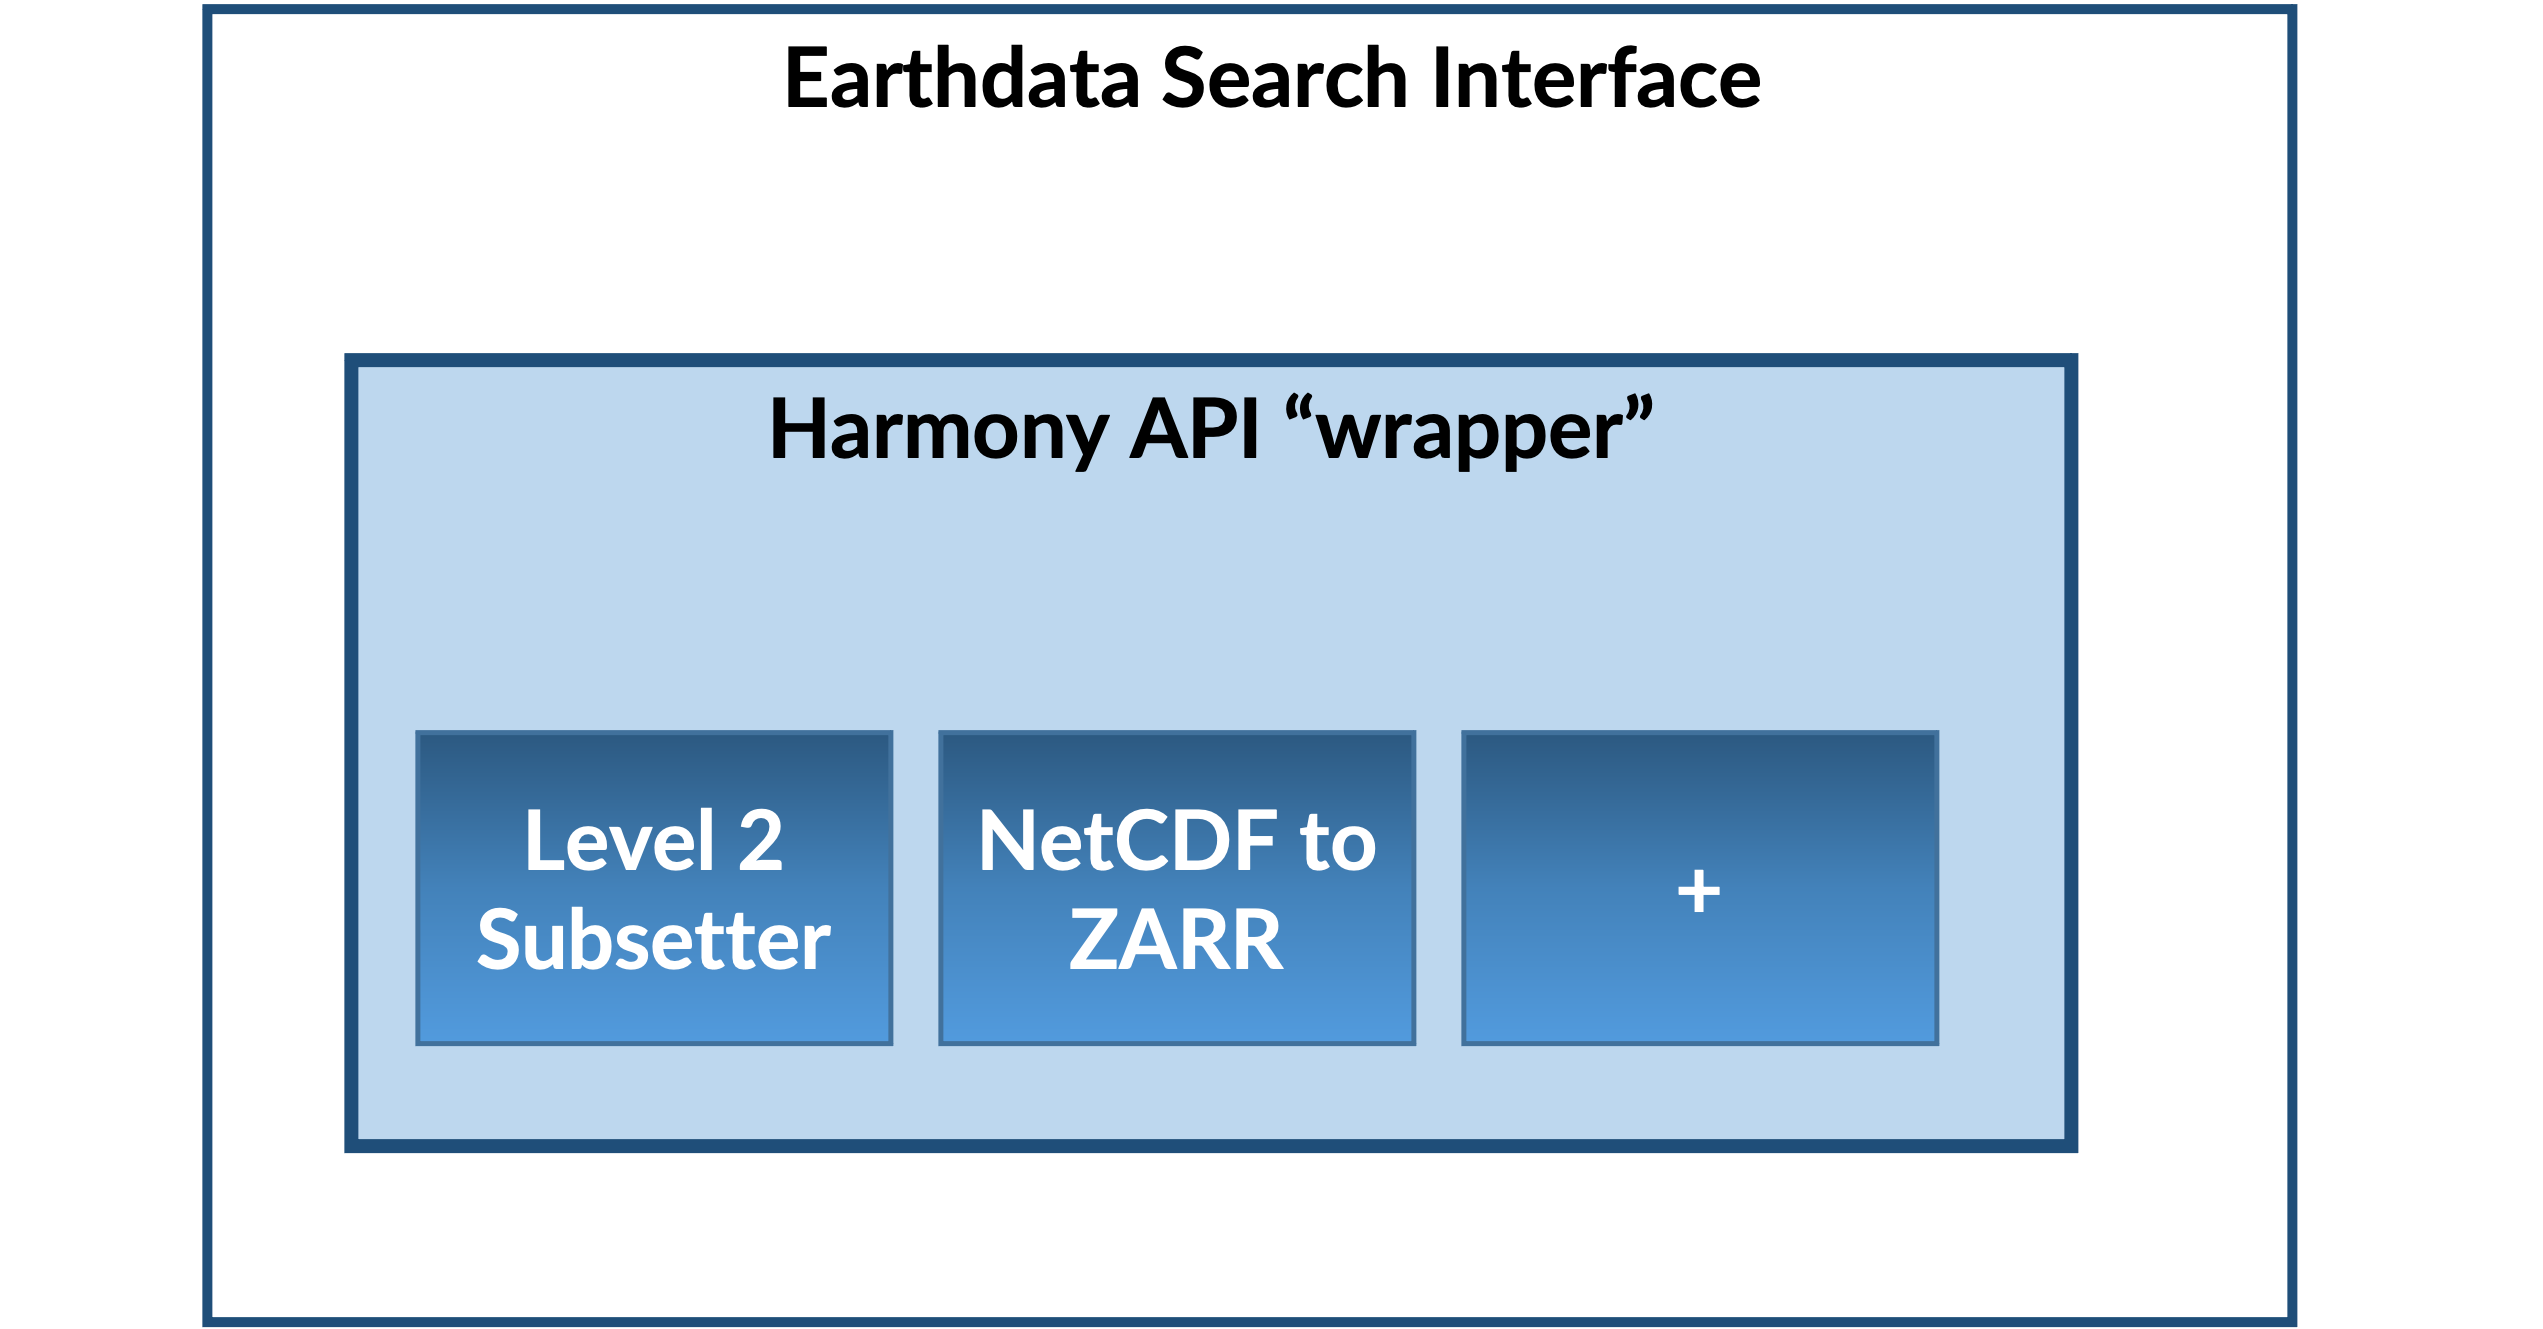

Harmony services **can be invoked through curl commands**, e.g.:

> https://harmony.earthdata.nasa.gov/{collectionId}/ogc-api-coverages/1.0.0/{variable}/coverage/rangeset

(Harmony services REST API conforms to the OGC Coverages API version 1.0.0. It accepts parameters in the URL path as well as query parameters.)


Harmony **can also be invoked via wrapper libraries such as `harmony-py`**, which is demonstrated below.

## 1. Setup

In [8]:
# Load packages into current runtime
import datetime as dt
import getpass

import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt

from harmony import BBox, Client, Collection, Request
from harmony.config import Environment

## 2. Retrieve a data file (via Harmony)

All users will need an Earthdata Login (EDL) account in order to access NASA data and services. 

Once a user has an EDL username and password they will need to use these when accessing Harmony.

In [9]:
print("Please provide your Earthdata Login credentials to allow data access")
print("Your credentials will only be passed to Earthdata and will not be exposed in the notebook")
username = input("Username:")

harmony_client = Client(env=Environment.PROD, auth=(username, getpass.getpass()))

Please provide your Earthdata Login credentials to allow data access
Your credentials will only be passed to Earthdata and will not be exposed in the notebook


Username: dkaufas
 ········


Choose a granule, and write out the request with a chosen *collection* ID and *granule* name.

In this case, we'll choose a granule (a ~6 minute window) containing nitrogen dioxide data crossing part of the great lakes region.

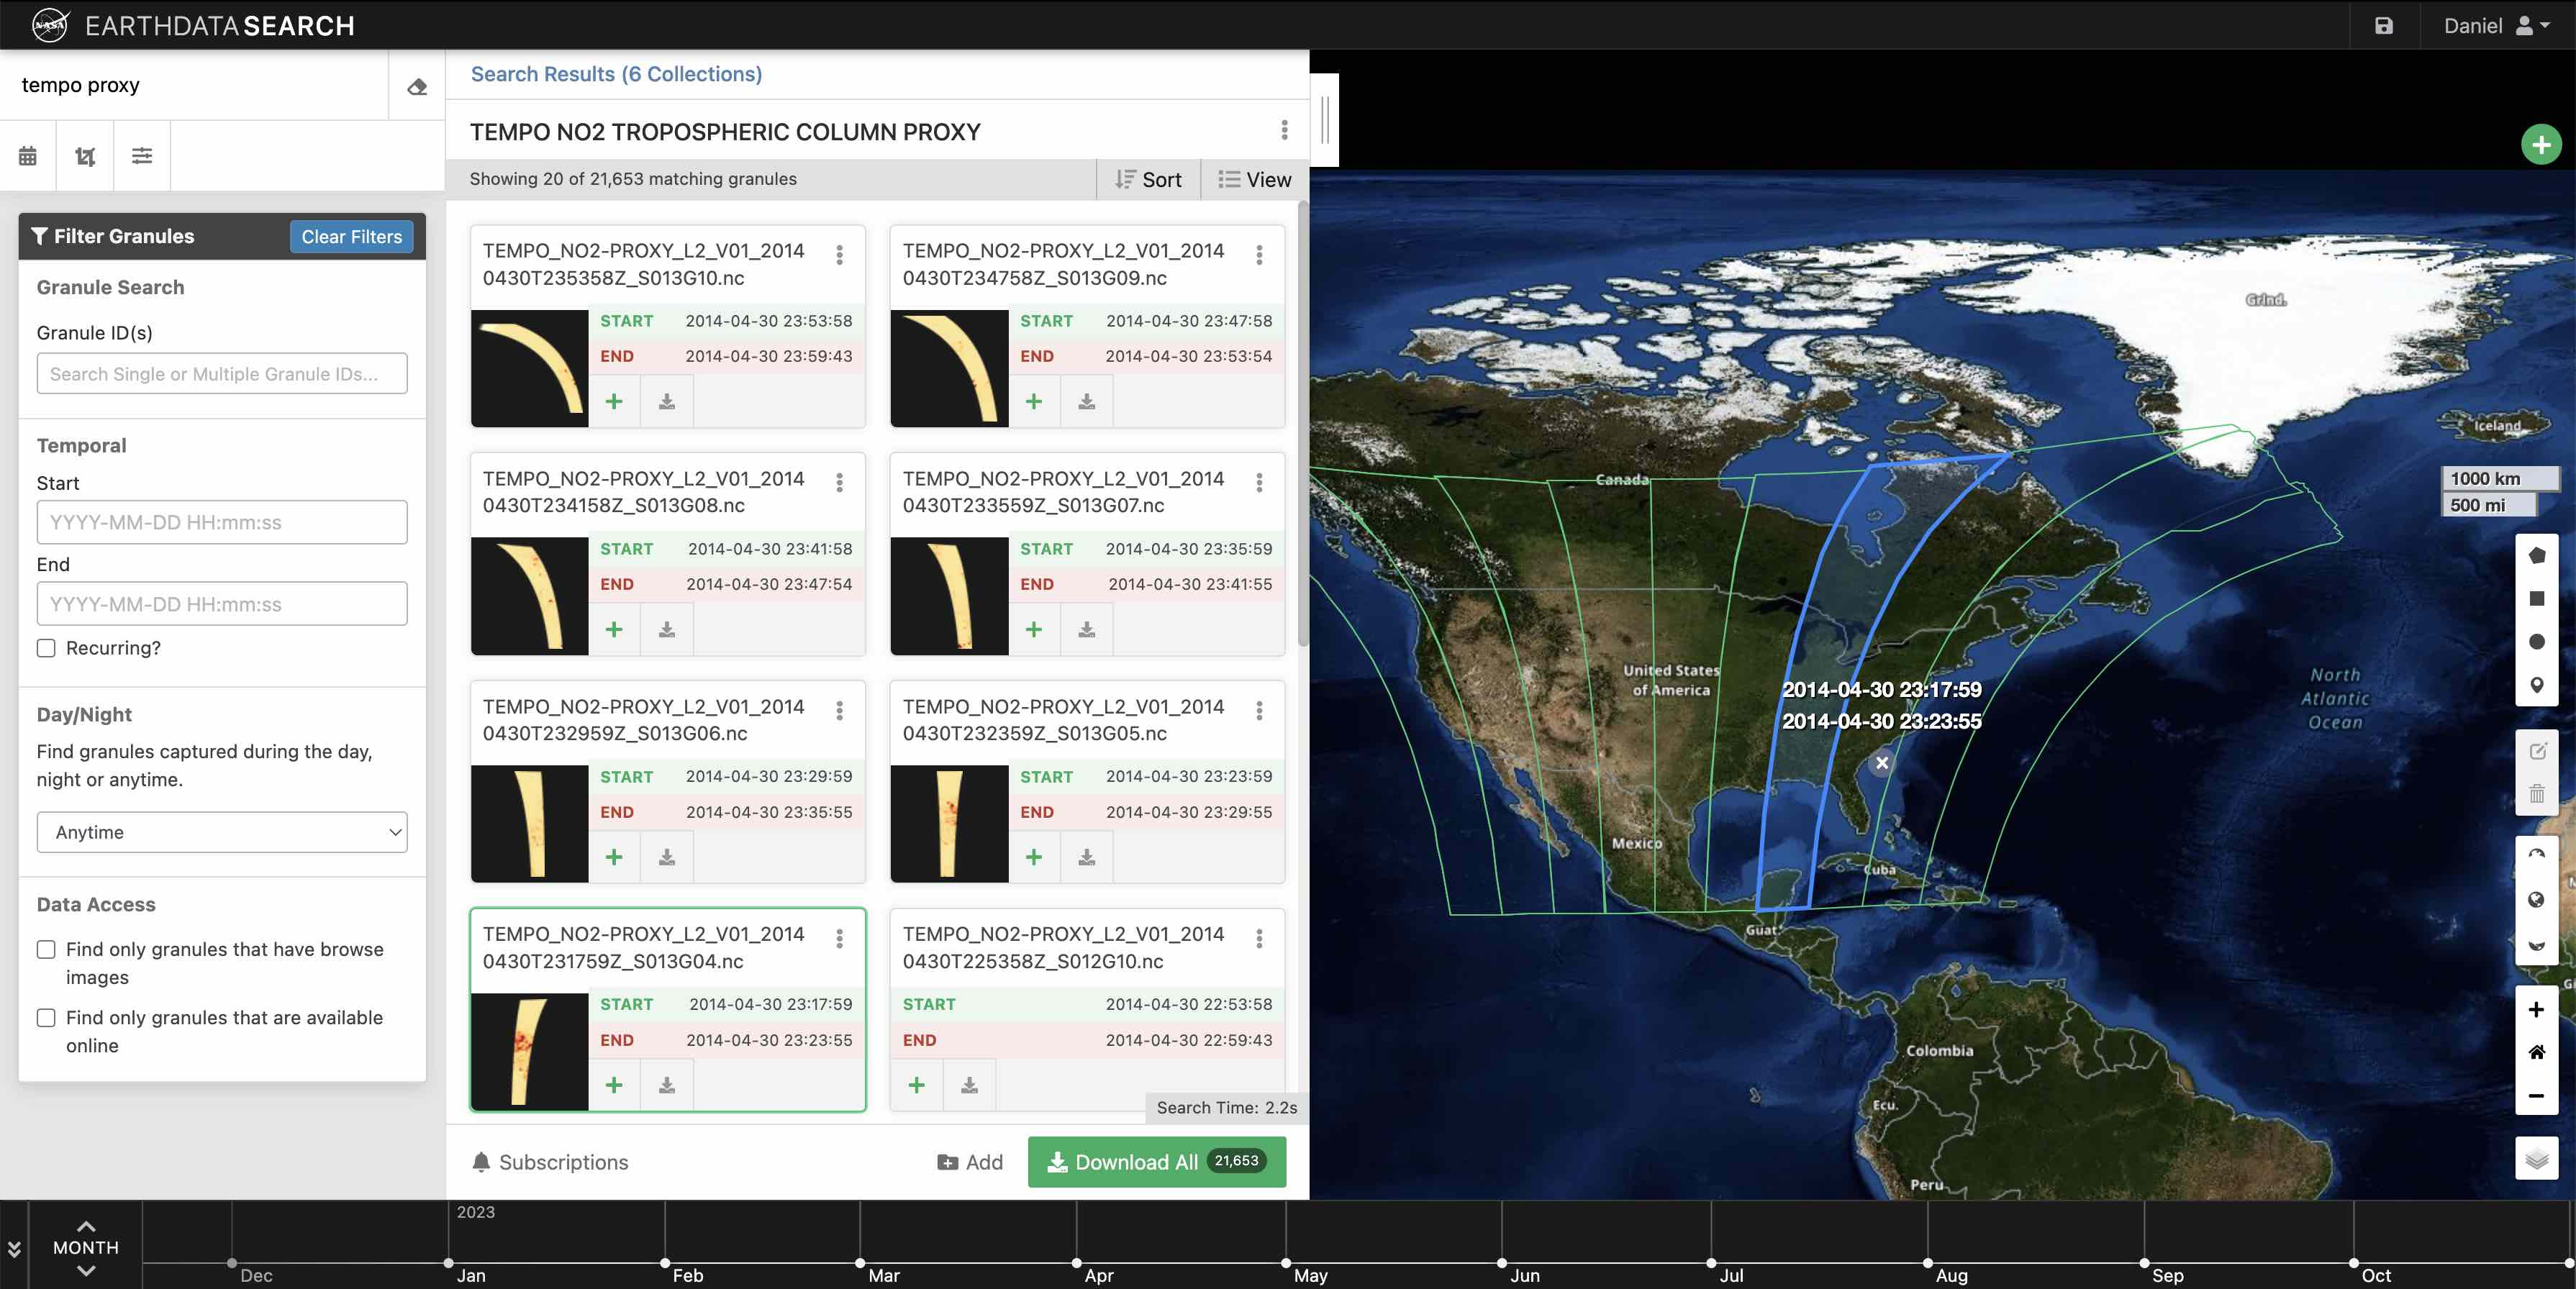

In [10]:
# "Nitrogen Dioxide total column"
request = Request(
    collection=Collection(id="C2930725014-LARC_CLOUD"),
    granule_name=["TEMPO_NO2_L2_V03_20250406T215103Z_S012G07.nc"],
)
request.is_valid()

True

In [11]:
# Submit the request
job_id = harmony_client.submit(request)
print(f"jobID = {job_id}")

# Wait for the processing to complete.
harmony_client.wait_for_processing(job_id, show_progress=True)

jobID = b7cb8b30-429e-4c9a-ad3a-6fe022427b6a


 [ Processing: 100% ] |###################################################| [|]


In [12]:
# Download the resulting files
results = harmony_client.download_all(job_id, directory="/tmp")
all_results_stored = [f.result() for f in results]

print(f"Number of result files: {len(all_results_stored)}")

/tmp/TEMPO_NO2_L2_V03_20250406T215103Z_S012G07.nc
/tmp/TEMPO_NO2_L2_V03_20250406T215103Z_S012G07.nc
Number of result files: 2


## 3. Open the data file

In [13]:
# Open the data file using the Xarray package.
#   Alternatively, one could use the netCDF4-python library.
ds_root = xr.open_dataset(all_results_stored[0])
ds_geo = xr.open_dataset(all_results_stored[0], group="geolocation")
ds_product = xr.open_dataset(all_results_stored[0], group="product")

# Merge the groups since Xarray doesn't yet natively combine groups for netCDF4
ds = xr.merge([ds_root, ds_geo, ds_product])
ds

<xarray.Dataset> Size: 24MB
Dimensions:                                  (xtrack: 2048, mirror_step: 131,
                                              corner: 4)
Coordinates:
  * xtrack                                   (xtrack) int32 8kB 0 1 ... 2047
  * mirror_step                              (mirror_step) int32 524B 788 ......
    time                                     (mirror_step) datetime64[ns] 1kB ...
    latitude                                 (mirror_step, xtrack) float32 1MB ...
    longitude                                (mirror_step, xtrack) float32 1MB ...
Dimensions without coordinates: corner
Data variables:
    latitude_bounds                          (mirror_step, xtrack, corner) float32 4MB ...
    longitude_bounds                         (mirror_step, xtrack, corner) float32 4MB ...
    solar_zenith_angle                       (mirror_step, xtrack) float32 1MB ...
    solar_azimuth_angle                      (mirror_step, xtrack) float32 1MB ...
    viewing_zenith_angle                     (mirror_step, xtrack) float32 1MB ...
    viewing_azimuth_angle                    (mirror_step, xtrack) float32 1MB ...
    relative_azimuth_angle                   (mirror_step, xtrack) float32 1MB ...
    main_data_quality_flag                   (mirror_step, xtrack) float32 1MB ...
    vertical_column_troposphere              (mirror_step, xtrack) float64 2MB ...
    vertical_column_stratosphere             (mirror_step, xtrack) float64 2MB ...
    vertical_column_troposphere_uncertainty  (mirror_step, xtrack) float64 2MB ...
Attributes: (12/38)
    tio_commit:                       bd5e3a3bec43c1970873e2537a09576f5e1d10df
    product_type:                     NO2
    processing_level:                 2
    processing_version:               3
    sdpc_version:                     TEMPO_SDPC_v4.4.3
    scan_num:                         12
    ...                               ...
    collection_shortname:             TEMPO_NO2_L2
    collection_version:               1
    keywords:                         EARTH SCIENCE>ATMOSPHERE>AIR QUALITY>NI...
    summary:                          Nitrogen dioxide Level 2 files provide ...
    coremetadata:                     \nGROUP                  = INVENTORYMET...
    history:                          2025-04-07T02:04:27Z:/tempo/nas0/sdpc_s...

## 4. Visualize one of the data variables

### Map

Here we take a look at the Vertical Column Total variable, both its metadata and then by creating a map visualization. Note the use of `main_data_quality_flag` in the plotting code to ensure that we are examining only the "normal" quality data.

In [14]:
product_variable_name = "vertical_column_troposphere"
ds[product_variable_name]

<xarray.DataArray 'vertical_column_troposphere' (mirror_step: 131, xtrack: 2048)> Size: 2MB
[268288 values with dtype=float64]
Coordinates:
  * xtrack       (xtrack) int32 8kB 0 1 2 3 4 5 ... 2043 2044 2045 2046 2047
  * mirror_step  (mirror_step) int32 524B 788 789 790 791 ... 915 916 917 918
    time         (mirror_step) datetime64[ns] 1kB ...
    latitude     (mirror_step, xtrack) float32 1MB ...
    longitude    (mirror_step, xtrack) float32 1MB ...
Attributes:
    long_name:  troposphere nitrogen dioxide vertical column
    units:      molecules/cm^2

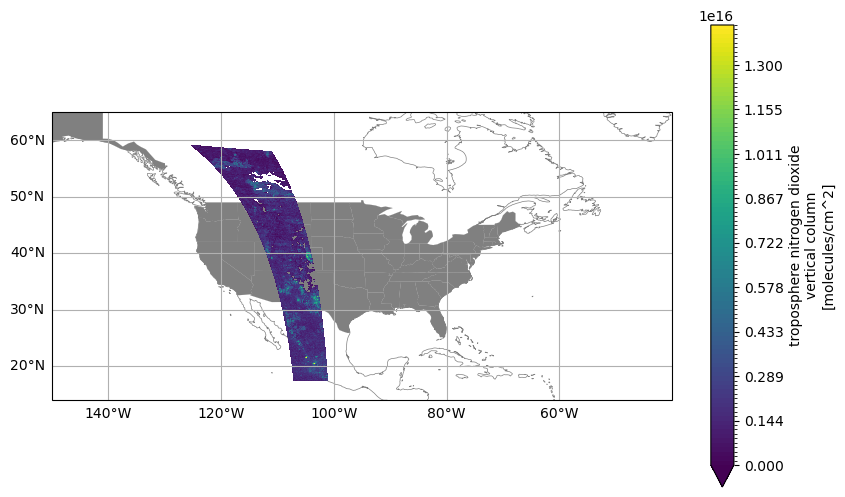

In [43]:
data_proj = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": data_proj})

ax.add_feature(cfeature.STATES, color="gray", lw=0.1)
ax.coastlines(resolution="50m", color="gray", linewidth=0.5)

contour_handle = (
    ds[product_variable_name]
    .where(ds["main_data_quality_flag"] == 0)
    .plot.contourf(ax=ax, x="longitude", y="latitude", levels=100, vmin=0, zorder=2)
)

ax.set_extent([-150, -40, 14, 65], crs=data_proj)
grid = ax.gridlines(draw_labels=["left", "bottom"], dms=True)
grid.xformatter = LONGITUDE_FORMATTER
grid.yformatter = LATITUDE_FORMATTER

plt.show()

### Zonal means

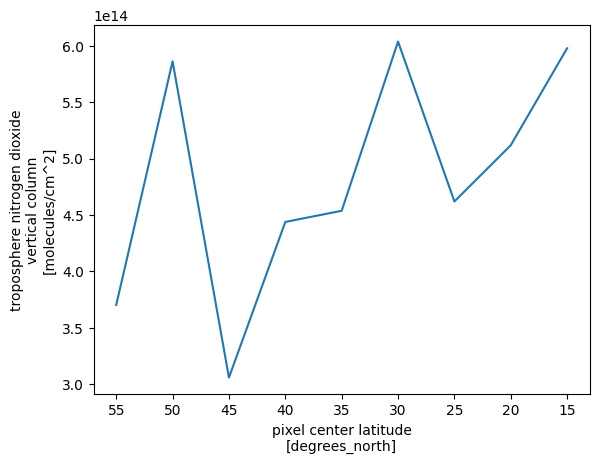

In [11]:
# Define two-degree wide latitude bins.
lat_bins = np.arange(15, 61, 5)
# Define a label for each bin corresponding to the central latitude.
lat_center = np.arange(15, 60, 5)
# Group according to those bins and take the mean.
product_lat_mean = (
    ds[product_variable_name]
    .groupby_bins("latitude", lat_bins, labels=lat_center)
    .mean(dim=xr.ALL_DIMS)
)

product_lat_mean.plot()
plt.gca().invert_xaxis()

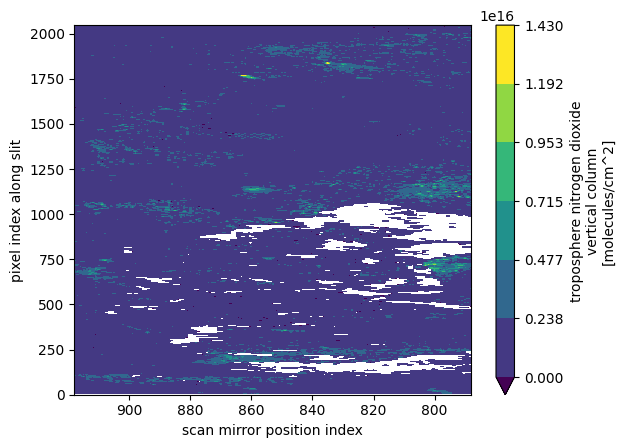

In [12]:
(
    ds_product[product_variable_name]
    .where(ds["main_data_quality_flag"] == 0)
    .plot.contourf(x="mirror_step", y="xtrack", vmin=0)
)
plt.gca().invert_xaxis()
plt.show()

## 5. Retrieve only a single variable

In [13]:
# TEMPO Formaldehyde
request = Request(
    collection=Collection(id="C2930730944-LARC_CLOUD"),
    granule_name=["TEMPO_HCHO_L2_V03_20231230T145736Z_S003G08.nc"],
    variables=["product/vertical_column"],
)

job_id = harmony_client.submit(request)
print(f"jobID = {job_id}")
harmony_client.wait_for_processing(job_id, show_progress=True)

# Download the resulting files
results = harmony_client.download_all(job_id, directory="/tmp", overwrite=True)
all_results_stored = [f.result() for f in results]
print(f"Number of result files: {len(all_results_stored)}")

jobID = 94198013-50c5-4964-a647-80ab1ba31fd6


 [ Processing: 100% ] |###################################################| [|]


Number of result files: 1


In [14]:
# Open the data file, in this case using the Xarray package
ds_root = xr.open_dataset(all_results_stored[0])
ds_geo = xr.open_dataset(all_results_stored[0], group="geolocation")
ds_product = xr.open_dataset(all_results_stored[0], group="product")

# Merge the groups since Xarray doesn't yet natively combine groups for netCDF4
ds = xr.merge([ds_root, ds_geo, ds_product])
ds

<xarray.Dataset> Size: 4MB
Dimensions:          (mirror_step: 131, xtrack: 2048)
Dimensions without coordinates: mirror_step, xtrack
Data variables:
    time             (mirror_step) datetime64[ns] 1kB ...
    latitude         (mirror_step, xtrack) float32 1MB ...
    longitude        (mirror_step, xtrack) float32 1MB ...
    vertical_column  (mirror_step, xtrack) float64 2MB ...
Attributes: (12/39)
    tio_commit:                       040d27c76f5040d777912886b53b0f3a5cbb3e67
    product_type:                     HCHO
    processing_level:                 2
    processing_version:               3
    sdpc_version:                     TEMPO_SDPC_v4.4.2
    scan_num:                         3
    ...                               ...
    collection_version:               1
    keywords:                         EARTH SCIENCE>ATMOSPHERE>AIR QUALITY>VO...
    summary:                          Formaldehyde Level 2 files provide trac...
    coremetadata:                     \nGROUP                  = INVENTORYMET...
    history:                          2024-08-05T19:15:47Z:/tempo/nas0/sdpc_s...
    history_json:                     [{"date_time": "2025-04-08T13:07:51.985...

Note the reduced list of data variables.

## 6. Retrieve data from a select time range

In [15]:
# @title
# A clean-up step to ensure there isn't a clash between newly downloaded granules
for rf in all_results_stored:
    !rm {rf}

In [16]:
request = Request(
    collection=Collection(id="C2930730944-LARC_CLOUD"),
    # Note there is not a granule specified!
    temporal={
        "start": dt.datetime(2023, 12, 30, 22, 30, 0),
        "stop": dt.datetime(2023, 12, 30, 22, 45, 0),
    },
)

job_id = harmony_client.submit(request)

print(f"jobID = {job_id}")
harmony_client.wait_for_processing(job_id, show_progress=True)

# Download the resulting files
results = harmony_client.download_all(job_id, directory="/tmp", overwrite=True)
all_results_stored = [f.result() for f in results]
print(f"Number of result files: {len(all_results_stored)}")

jobID = 981a3617-4a68-4ca2-8594-274737037834


 [ Processing: 100% ] |###################################################| [|]


Number of result files: 4


In [17]:
# Open the data files
ds_dict = dict()
for r in sorted(all_results_stored):
    ds_root = xr.open_dataset(r)
    ds_geo = xr.open_dataset(r, group="geolocation")
    ds_product = xr.open_dataset(r, group="product")

    ds_dict[r] = xr.merge([ds_root, ds_geo, ds_product])

    print(f"Time range: {ds_dict[r]['time'].values.min()} - {ds_dict[r]['time'].values.max()}")

Time range: 2023-12-30T22:30:00.279620864 - 2023-12-30T22:31:19.139312896
Time range: 2023-12-30T22:31:22.172382976 - 2023-12-30T22:37:56.470801152
Time range: 2023-12-30T22:37:59.503866880 - 2023-12-30T22:44:33.802316800
Time range: 2023-12-30T22:44:36.835376128 - 2023-12-30T22:44:58.066825984


Note how the time ranges fit within the requested temporal range

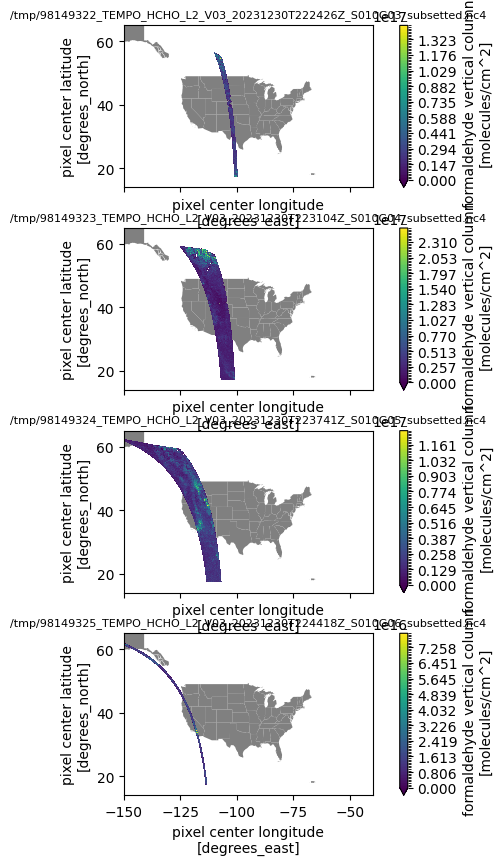

In [18]:
# Visualize each data file
data_proj = ccrs.PlateCarree()

fig, axs = plt.subplots(
    nrows=len(ds_dict),
    ncols=1,
    sharex=True,
    figsize=(7, 10),
    gridspec_kw=dict(hspace=0.25),
    subplot_kw={"projection": data_proj},
)
for i, (dk, dv) in enumerate(ds_dict.items()):
    Var = dv["vertical_column"]
    ax = axs[i]
    if np.count_nonzero(~np.isnan(Var.values)) > 0:
        ax.add_feature(cfeature.STATES, color="gray", lw=0.1)
        ax.coastlines(resolution="50m", color="gray", linewidth=0.5)

        Var.plot.contourf(ax=ax, x="longitude", y="latitude", levels=100, vmin=0)

        ax.set_xlim((-150, -40))
        ax.set_ylim((14, 65))
        ax.set_title(dk, fontsize=8)

plt.show()

In [19]:
# A clean-up step to ensure there isn't a clash between newly downloaded granules
for rf in all_results_stored:
    !rm {rf}

## 7. Retrieve data from a spatial bounding box

In [20]:
request = Request(
    collection=Collection(id="C2930730944-LARC_CLOUD"),
    # Note there is not a granule specified!
    spatial=BBox(-115, 35, -95, 45),
    temporal={
        "start": dt.datetime(2023, 12, 30, 22, 30, 0),
        "stop": dt.datetime(2023, 12, 30, 22, 45, 0),
    },
)

job_id = harmony_client.submit(request)

print(f"jobID = {job_id}")
harmony_client.wait_for_processing(job_id, show_progress=True)

# Download the resulting files
results = harmony_client.download_all(job_id, directory="/tmp", overwrite=True)
all_results_stored = [f.result() for f in results]
print(f"Number of result files: {len(all_results_stored)}")

jobID = 67b89942-4e0a-4f6f-b893-00d995fa1f51


 [ Processing: 100% ] |###################################################| [|]


Number of result files: 3


In [21]:
# Open the data files
ds_dict = dict()
for r in sorted(all_results_stored):
    ds_root = xr.open_dataset(r)
    ds_geo = xr.open_dataset(r, group="geolocation")
    ds_product = xr.open_dataset(r, group="product")

    ds_dict[r] = xr.merge([ds_root, ds_geo, ds_product])

In [22]:
# ds_dict['/tmp/TEMPO_NO2-PROXY_L2_V01_20140430T222959Z_S012G06_subsetted.nc4']['vertical_column_total']

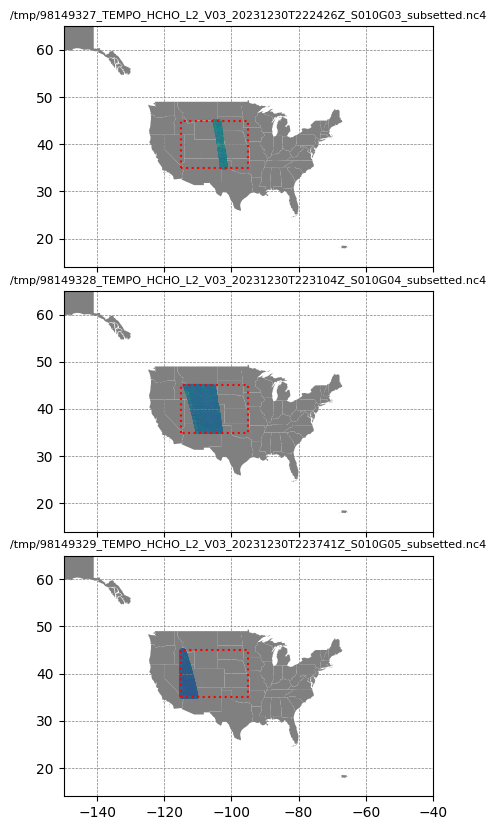

In [23]:
# Visualize each data file
data_proj = ccrs.PlateCarree()

fig, axs = plt.subplots(
    nrows=len(ds_dict),
    ncols=1,
    sharex=True,
    figsize=(7, 10),
    gridspec_kw=dict(hspace=0.1),
    subplot_kw={"projection": data_proj},
)
for i, (dk, dv) in enumerate(ds_dict.items()):
    Var = dv["vertical_column"]
    ax = axs[i]
    if np.count_nonzero(~np.isnan(Var.values)) > 0:
        # Zm = ma.masked_where(np.isnan(Var), Var)
        # Var[:] = Zm
        # Var.plot(x='longitude', y='latitude', ax=axs[i])
        ax.add_feature(cfeature.STATES, color="gray", lw=0.1)
        ax.coastlines(resolution="50m", color="gray", linewidth=0.5)

        ax.scatter(dv["longitude"], dv["latitude"], s=1, c=dv["vertical_column"])
        ax.set_title(dk, fontsize=8)
        ax.set_xlim((-150, -40))
        ax.set_ylim((14, 65))
        ax.grid(color="gray", linestyle="--", linewidth=0.5)

        # Coordinates of rectangle vertices in clockwise order
        xs = [-115, -115, -95, -95, -115]
        ys = [35, 45, 45, 35, 35]
        ax.plot(xs, ys, color="red", linestyle=":")

plt.show()

Note the cut-off of data for the bounding box: (-115, 35, -95, 45)

End of Notebook.